<center>

# **Fine-tuning RoBERTa for Emotion Classification on MELD**

## In this notebook, I fine-tune a pretrained RoBERTa model to perform emotion classification on the MELD dataset.
# MELD (https://affective-meld.github.io) contains short, context-rich dialogues labeled with fine-grained emotion categories. Many utterances are only a few words long, and the conversational structure includes multiple speakers. The data also includes audio and videos that accompany the utterances, but only the text is used in this notebook. Finetuning on a multimodal dataset might have required far more compute. 
# The model is trained using a standard cross-entropy loss, and a learning rate scheduler is used to improve optimization. 
## I monitor batch-wise and epoch-wise training and validation performance, and save the best model based on validation loss.

</center>

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
import tarfile
import os
# import warnings
# warnings.filterwarnings('ignore')

<center>

# **Loading the MELD Dataset**
## MELD (Multimodal EmotionLines Dataset) is a richly annotated dataset of multiparty conversations extracted from the TV series *Friends*. 
# It contains utterance-level emotion labels for each speaker turn in a dialogue.
## The version used here contains only the text and emotion labels. Each dialogue is relatively short, and many utterances are just a few words long, making it a challenging dataset for contextual emotion classification. You can see what the data looks like from the first few rown of the dataframe printed in this cell.


</center>

In [2]:
# Load the data
base_path = '/kaggle/input/meld-text/All_Meld_Text/'
train_df = pd.read_csv(base_path + 'train_sent_emo.csv')
dev_df = pd.read_csv(base_path + 'dev_sent_emo.csv')
test_df = pd.read_csv(base_path + 'test_sent_emo.csv')

print(train_df.columns)
train_df.head()

Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


<center>

# Here I do some basic inspection of the data. This data has already been prepped and labeled with emotion labels. So not much pre-processing is necessary
## We can see that we dont have a very long context window here. All the dialogues are relatively short.
# Most utterances are short, With some as short as a single word.

</center>

Longest dialogue by utterance count: Dialogue_ID 54 with 24 utterances
Longest dialogue by character count: Dialogue_ID 450 with 1566 characters


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Longest dialogue translates to 369 tokens


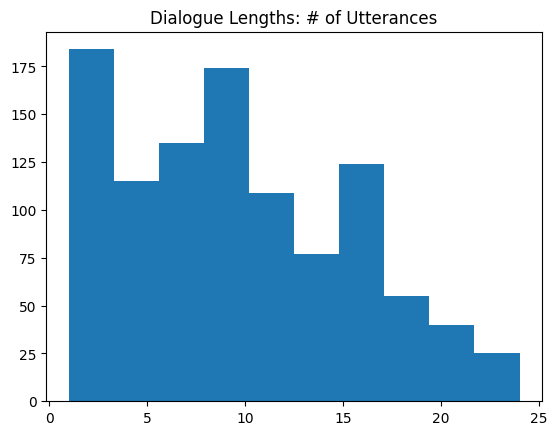

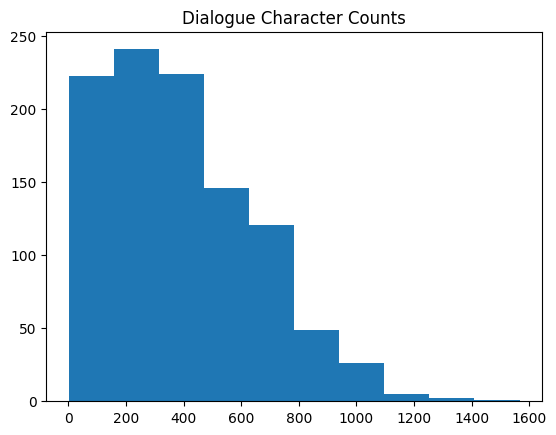

In [3]:

grouped = train_df.groupby('Dialogue_ID')

# Dialogue with the most utterances
dialogue_lengths = grouped.size()
max_utterances_id = dialogue_lengths.idxmax()
max_utterances_count = dialogue_lengths.max()

# Dialogue with the most characters
dialogue_char_counts = grouped['Utterance'].apply(lambda x: sum(len(utt) for utt in x))
max_chars_id = dialogue_char_counts.idxmax()
max_chars_count = dialogue_char_counts.max()

print(f"Longest dialogue by utterance count: Dialogue_ID {max_utterances_id} with {max_utterances_count} utterances")
print(f"Longest dialogue by character count: Dialogue_ID {max_chars_id} with {max_chars_count} characters")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
longest = " ".join(train_df[train_df['Dialogue_ID'] == max_utterances_id]['Utterance'].tolist())
tokens = tokenizer.tokenize(longest)
print(f'Longest dialogue translates to {len(tokens)} tokens')

plt.hist(dialogue_lengths)
plt.title('Dialogue Lengths: # of Utterances')
plt.show()
plt.hist(dialogue_char_counts)
plt.title('Dialogue Character Counts')
plt.show()

## I intend to add additional special tokens to the tokenizer so that the model learns turn taking behaviour (hopefully) which might improve performance. Therefore I am inspecting what the max number of speakers in a dialogue is. 

The max number of speakers in a single dialogue is 9


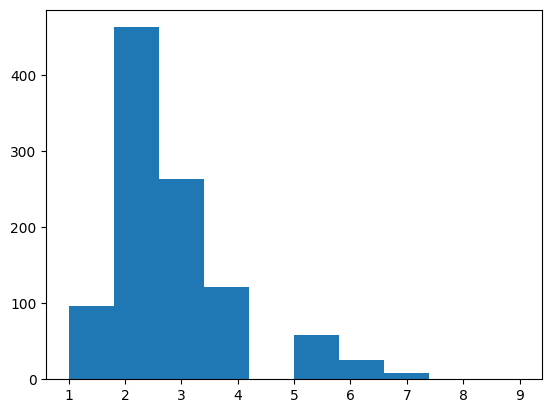

In [4]:
# Check number of speakers in each dialogue
num_speakers = []
for thisid in train_df['Dialogue_ID'].unique():
    this_dialogue = train_df[train_df['Dialogue_ID'] == thisid]
    num_speakers.append(len(this_dialogue['Speaker'].unique()))

print(f'The max number of speakers in a single dialogue is {np.max(num_speakers)}')
plt.hist((num_speakers))
plt.show()
# So I can add 9 Speaker ID Tokens to the tokenizer

### Here I was trying to see if we can augment the data by using another model to paraphrase each utterance first.  This did not work very well. There may be other ways to agument the data to enhance classification performance. I did not persue this further due to time and compute constraints.

In [ ]:
# from transformers import pipeline
# paraphraser = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws", device=0)
# train_df2 = train_df.copy()
# batch_size = 32  # or 64 if memory allows
# texts = train_df2['Utterance'].tolist()

# augmented_texts = []

# for i in tqdm(range(0, len(texts), batch_size)):
#     batch = texts[i:i+batch_size]
#     batch_to_paraphrase = [t for t in batch if len(t.strip().split()) >= 3]
    
#     # Paraphrase only the longer ones
#     paraphrased = paraphraser(
#         [f"paraphrase: {text} </s>" for text in batch_to_paraphrase],
#         max_length=256,
#         num_return_sequences=1,
#         do_sample=True
#     )

#     # Replace paraphrasable ones, leave others unchanged
#     idx = 0
#     for t in batch:
#         if len(t.strip().split()) >= 3:
#             augmented_texts.append(paraphrased[idx]['generated_text'])
#             idx += 1
#         else:
#             augmented_texts.append(t)

# train_df2['Utterance'] = augmented_texts
# train_df2.to_csv('/kaggle/working/augmented_train_df.csv', index=False)

<center>

## Now we build our training data by adding context progressively to each utterance in a dialogue. For example, we utterance 4 in a dialogue is prepended with utterances 1 to 3 as well. This will hopefully give the model some contextual understanding of the emotions associated with the utterance. 
## I also define the custom model class and create the special tokens for speakers

</center>

In [5]:
# Load the model and tokenizer
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
print(f'Tokenizer length before adding new tokens = {len(tokenizer)}')

# Add special tokens for speakers
special_speaker_tokens = [f"<speaker{i}>" for i in range(1, 10)]  # speaker1 to speaker9
tokenizer.add_special_tokens({'additional_special_tokens': special_speaker_tokens}) # Add the new tokens to the tokenizer
print(f'Tokenizer length after adding new tokens = {len(tokenizer)}')
max_length = tokenizer.model_max_length
sep_token = tokenizer.sep_token # This is the separator token for later use

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"<speaker{i+1}>" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = f" {sep_token} ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer length before adding new tokens = 50265
Tokenizer length after adding new tokens = 50274


<center>

## **Model Preparation for Fine-Tuning**
## In this step, I prepare the RoBERTa model for emotion classification.

#### RoBERTa (A Robustly Optimized BERT Pretraining Approach) is a transformer-based language model developed by Facebook AI (https://arxiv.org/abs/1907.11692). It builds on BERT but improves performance by training longer, on more data, with larger batch sizes, and by removing BERT’s next-sentence prediction objective.

#### RoBERTa is pretrained using a masked language modeling (MLM) task: it learns to predict masked-out words in a sentence using the surrounding context. This allows it to learn rich representations of language structure and semantics.

## I freeze all pretrained layers initially, then selectively unfreeze the last two transformer layers to allow limited fine-tuning.
## A custom classification head is added on top of the CLS token representation to predict one of 7 emotion labels.
## The model is then wrapped in a custom PyTorch module to make it ready for training.

</center>

In [6]:
# I am now preparing the model for fine tuning
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 2 transformer layers of the encoder
for layer in model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Define a new classification head
class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Instantiate our custom model
num_labels = len(set(train_labels))  # 7 emotions
Full_model = RobertaForEmotionClassification(model, num_labels)
Full_model.roberta.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50274, 768, padding_idx=1)

<center>

### Create the data loaders for the training loop


<center>

In [7]:
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
train_dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = train_dataset.map(tokenize_batch, batched=True, batch_size=32)
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Sanity check
print(train_tokenized[0].keys())


# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'attention_mask'])


Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

<center>


### Here is an example of what I have done with the data. 

<Center>

In [23]:
from random import randint
import textwrap
# Show how one contextual input looks (random sample)
random_idx = randint(0, len(train_inputs) - 1)
print(f"Here is example of what we have done with the data: ")
print(f"\n We added the speaker tokens. And we progressively prepend context to each utterance in a dialogue")
print(f"\n Example {random_idx} — Contextualized Input:\n")
print(textwrap.fill(train_inputs[random_idx], width=100))
print(f"\n Label: {train_labels[random_idx]}  → Encoded as: {encoded_labels[random_idx]}")

# Show tokenized version for the same example
tokenized_example = train_tokenized[random_idx]
print(" Number of tokens:", len(tokenized_example['input_ids']))

# Decode first few tokens to show what model will see
decoded_preview = tokenizer.decode(tokenized_example['input_ids'][:50], skip_special_tokens=False)
print("\n Decoded token (first 50 tokens):")
print(textwrap.fill(decoded_preview, width=100))

Here is example of what we have done with the data: 

 We added the speaker tokens. And we progressively prepend context to each utterance in a dialogue

 Example 7395 — Contextualized Input:

<speaker1>: Hey Joey, I got some beer for you. </s> <speaker2>: Uh, don't you mean "for whom?" </s>
<speaker1>: Sure, listen I was gonna order some pizza, you wanna share one?

 Label: neutral  → Encoded as: 4
 Number of tokens: 512

 Decoded token (first 50 tokens):
<s> <speaker1> : Hey Joey, I got some beer for you. </s>  <speaker2> : Uh, don't you mean "for
whom?" </s>  <speaker1> : Sure, listen I was gonna order some pizza, you wanna share one?</s><pad>


<Center>

# **Fine-Tuning Setup and Training Loop**

# In this section, the RoBERTa-base model is fine-tuned on the MELD dataset for emotion classification.
# We begin by preparing the model for training: assigning it to the GPU (I used Kaggle GPUs), setting up the AdamW optimizer, and defining a cross-entropy loss function for multi-class classification.
# A linear learning rate scheduler with warm-up is also initialized to improve convergence stability.

# The training loop runs for 15 epochs. For each epoch:
# - The model is trained batch by batch, and the loss and accuracy are recorded.
# - After training, the model is evaluated on the validation set without gradient updates.
# - Validation loss and accuracy are calculated and logged.
# - The best-performing model (based on validation loss) is saved to disk as a checkpoint.
# - At the end of training, the final model is also saved.

# Throughout the training, various metrics (losses, accuracies, learning rates) are stored for post-hoc visualization and analysis.

<center>

In [9]:
# Now we can prepare for model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
optimizer = torch.optim.AdamW(Full_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

from transformers import get_linear_schedule_with_warmup
epochs = 15
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Store metrics for plotting
all_train_batch_losses = []
all_val_batch_losses = []
all_train_batch_acc = []
all_val_batch_acc = []
epoch_train_accuracies = []
epoch_val_accuracies = []
epoch_train_losses = []
epoch_val_losses = []
all_learning_rates = []
best_val_loss = float('inf')

for epoch in range(epochs):
    Full_model.train()
    train_loss = 0
    correct = 0
    total = 0
    epoch_batch_losses = []
    epoch_batch_acc = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        all_learning_rates.append(current_lr)

        loss_value = loss.item()
        train_loss += loss_value
        epoch_batch_losses.append(loss_value)

        _, preds = torch.max(outputs, dim=1)
        batch_correct = (preds == labels).sum().item()
        correct += batch_correct
        total += labels.size(0)

        batch_acc = batch_correct / labels.size(0)
        epoch_batch_acc.append(batch_acc)

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: LR = {current_lr:.6f}")
    print(f"Train loss: {avg_loss:.4f} | Train accuracy: {accuracy:.4f}")

    all_train_batch_losses.extend(epoch_batch_losses)
    all_train_batch_acc.extend(epoch_batch_acc)
    epoch_train_losses.append(avg_loss)
    epoch_train_accuracies.append(accuracy)

    # Validation loop
    Full_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_epoch_losses = []
    val_epoch_acc = []

    with torch.no_grad():
        for batch in tqdm(dev_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_epoch_losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)
            batch_correct = (preds == labels).sum().item()
            correct += batch_correct
            total += labels.size(0)

            batch_acc = batch_correct / labels.size(0)
            val_epoch_acc.append(batch_acc)

    avg_val_loss = val_loss / len(dev_loader)
    val_accuracy = correct / total

    print(f"Val loss: {avg_val_loss:.4f} | Val accuracy: {val_accuracy:.4f}")

    all_val_batch_losses.extend(val_epoch_losses)
    all_val_batch_acc.extend(val_epoch_acc)
    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(val_accuracy)

    # Save only if validation improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = f"/kaggle/working/Extended_Token_model_{epoch+1}.pt"
        torch.save({
            'model_state_dict': Full_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'val_loss': avg_val_loss
        }, checkpoint_path)
        print(f"New best model saved at {checkpoint_path}")
    if epoch == epochs - 1:
        torch.save(Full_model.state_dict(), "/kaggle/working/final_model.pt")

Epoch 1 - Training: 100%|██████████| 313/313 [03:59<00:00,  1.31it/s]


Epoch 1: LR = 0.000013
Train loss: 1.7065 | Train accuracy: 0.3621


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.5961 | Val accuracy: 0.4238
New best model saved at /kaggle/working/Extended_Token_model_1.pt


Epoch 2 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 2: LR = 0.000019
Train loss: 1.4069 | Train accuracy: 0.5172


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.2757 | Val accuracy: 0.5582
New best model saved at /kaggle/working/Extended_Token_model_2.pt


Epoch 3 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 3: LR = 0.000018
Train loss: 1.2023 | Train accuracy: 0.6011


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.1606 | Val accuracy: 0.5987
New best model saved at /kaggle/working/Extended_Token_model_3.pt


Epoch 4 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 4: LR = 0.000016
Train loss: 1.1233 | Train accuracy: 0.6237


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.1266 | Val accuracy: 0.6078
New best model saved at /kaggle/working/Extended_Token_model_4.pt


Epoch 5 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 5: LR = 0.000015
Train loss: 1.0855 | Train accuracy: 0.6362


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1192 | Val accuracy: 0.5924
New best model saved at /kaggle/working/Extended_Token_model_5.pt


Epoch 6 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 6: LR = 0.000013
Train loss: 1.0383 | Train accuracy: 0.6490


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1399 | Val accuracy: 0.6168


Epoch 7 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 7: LR = 0.000012
Train loss: 1.0129 | Train accuracy: 0.6568


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.0930 | Val accuracy: 0.6096
New best model saved at /kaggle/working/Extended_Token_model_7.pt


Epoch 8 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 8: LR = 0.000010
Train loss: 0.9759 | Train accuracy: 0.6695


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.0928 | Val accuracy: 0.6132
New best model saved at /kaggle/working/Extended_Token_model_8.pt


Epoch 9 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 9: LR = 0.000009
Train loss: 0.9498 | Train accuracy: 0.6756


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1013 | Val accuracy: 0.6132


Epoch 10 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 10: LR = 0.000007
Train loss: 0.9221 | Train accuracy: 0.6878


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1121 | Val accuracy: 0.6222


Epoch 11 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 11: LR = 0.000006
Train loss: 0.8961 | Train accuracy: 0.6921


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Val loss: 1.1119 | Val accuracy: 0.6294


Epoch 12 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 12: LR = 0.000004
Train loss: 0.8804 | Train accuracy: 0.6996


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.15it/s]


Val loss: 1.1344 | Val accuracy: 0.6267


Epoch 13 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 13: LR = 0.000003
Train loss: 0.8601 | Train accuracy: 0.7032


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1243 | Val accuracy: 0.6294


Epoch 14 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 14: LR = 0.000001
Train loss: 0.8577 | Train accuracy: 0.7017


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1272 | Val accuracy: 0.6258


Epoch 15 - Training: 100%|██████████| 313/313 [04:00<00:00,  1.30it/s]


Epoch 15: LR = 0.000000
Train loss: 0.8487 | Train accuracy: 0.7118


Validation: 100%|██████████| 70/70 [00:16<00:00,  4.16it/s]


Val loss: 1.1290 | Val accuracy: 0.6276


In [12]:
# Save batch-level training metrics
pd.DataFrame({
    'train_batch_loss': all_train_batch_losses,
    'train_batch_acc': all_train_batch_acc,
    'learning_rate': all_learning_rates
}).to_csv('/kaggle/working/train_batch_metrics.csv', index=False)

# Save batch-level validation metrics
pd.DataFrame({
    'val_batch_loss': all_val_batch_losses,
    'val_batch_acc': all_val_batch_acc
}).to_csv('/kaggle/working/val_batch_metrics.csv', index=False)

# Save epoch-level metrics
pd.DataFrame({
    'epoch_train_loss': epoch_train_losses,
    'epoch_train_acc': epoch_train_accuracies,
    'epoch_val_loss': epoch_val_losses,
    'epoch_val_acc': epoch_val_accuracies
}).to_csv('/kaggle/working/epoch_metrics.csv', index=False)

<center>

### I now do some visualisation of the losses and accuracy at the epoch level as well as the more noisy batch level. We can see that althought he training loss and accuracy were still improving, the validation metrics seem to have reached a plateau.

<center>

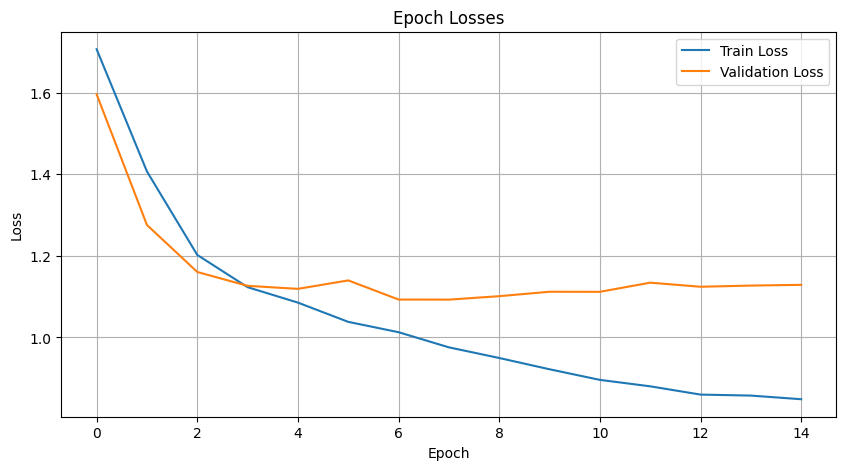

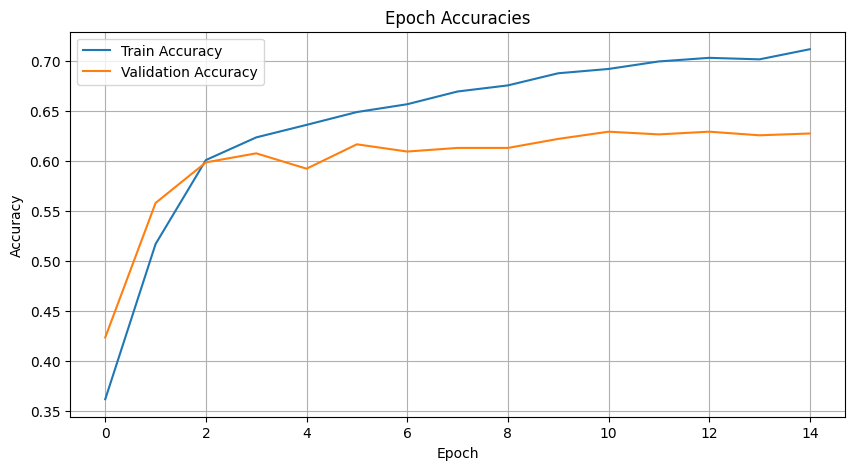

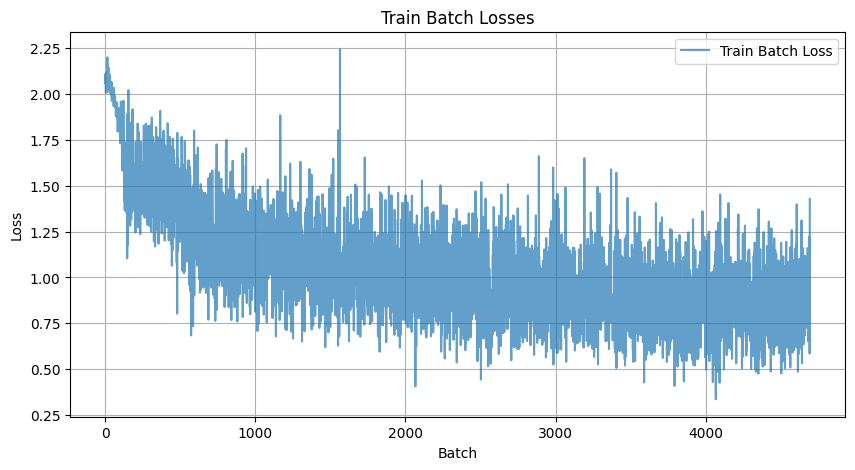

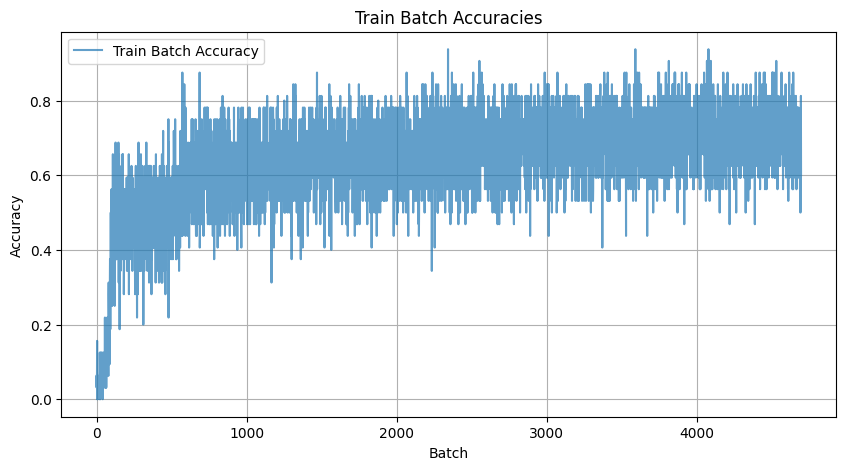

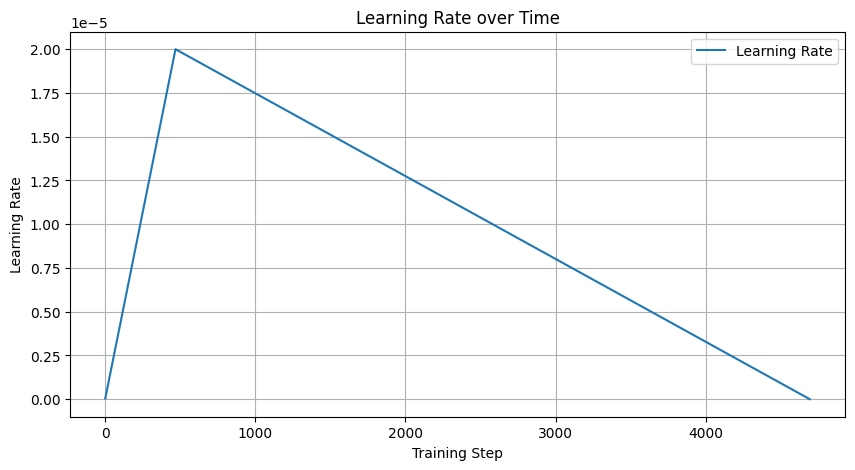

In [11]:
# Plot epoch-level losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_train_losses, label='Train Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title('Epoch Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot epoch-level accuracies
plt.figure(figsize=(10, 5))
plt.plot(epoch_train_accuracies, label='Train Accuracy')
plt.plot(epoch_val_accuracies, label='Validation Accuracy')
plt.title('Epoch Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot batch-level training loss
plt.figure(figsize=(10, 5))
plt.plot(all_train_batch_losses, label='Train Batch Loss', alpha=0.7)
plt.title('Train Batch Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot batch-level training accuracy
plt.figure(figsize=(10, 5))
plt.plot(all_train_batch_acc, label='Train Batch Accuracy', alpha=0.7)
plt.title('Train Batch Accuracies')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning rate schedule
plt.figure(figsize=(10, 5))
plt.plot(all_learning_rates, label='Learning Rate')
plt.title('Learning Rate over Time')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

<center>

# Here I test the performance of the model on the test set. We have Test Loss: 1.0445, Test Accuracy: 0.6533 and  Weighted F1 Score: 0.6325. These metrics are not incredible but are comparable to other groups that have fine tuned models based on RoBERTa as the base model. You can see this at the following link:
 https://paperswithcode.com/sota/emotion-recognition-in-conversation-on-meld

 <center>

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd
from datasets import Dataset
from transformers import RobertaModel, RobertaTokenizer

test_df = pd.read_csv('Path to test data/Re_Connect_Project/Data/test_sent_emo.csv')

# Load the model and tokenizer
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
print(f'Tokenizer length before adding new tokens = {len(tokenizer)}')

# Add special tokens for speakers
special_speaker_tokens = [f"<speaker{i}>" for i in range(1, 10)]  # speaker1 to speaker9
tokenizer.add_special_tokens({'additional_special_tokens': special_speaker_tokens}) # Add the new tokens to the tokenizer
print(f'Tokenizer length after adding new tokens = {len(tokenizer)}')
max_length = tokenizer.model_max_length
sep_token = tokenizer.sep_token # This is the separator token for later use

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"<speaker{i+1}>" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = f" {sep_token} ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

test_inputs, test_labels = build_dynamic_context_inputs(test_df)
# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
from torch.utils.data import DataLoader
test_loader = DataLoader(test_tokenized, batch_size=16)

# Define the same model architecture used during training
class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Reload pretrained base model
base_model = RobertaModel.from_pretrained("roberta-base")
num_labels = len(set(test_labels))  # should match your training setup

# Instantiate and load the saved model
Full_model = RobertaForEmotionClassification(base_model, num_labels)
Full_model.roberta.resize_token_embeddings(len(tokenizer))
# Load the full checkpoint
checkpoint = torch.load("Path to the saved models/Re_Connect_Project/Trained_Models/Extended_Token_model_8.pt", map_location='cpu')
Full_model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
Full_model.eval()

# Define loss function
criterion = nn.CrossEntropyLoss()

# Evaluate on test set
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = Full_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute average loss and metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(all_labels, all_preds)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n Test Loss: {avg_test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Weighted F1 Score: {weighted_f1:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer length before adding new tokens = 50265
Tokenizer length after adding new tokens = 50274


Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 164/164 [08:37<00:00,  3.16s/it]


 Test Loss: 1.0445
 Test Accuracy: 0.6533
 Weighted F1 Score: 0.6325
